In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi16')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1002.70it/s]

Using control points [0.00000000e+00 0.00000000e+00 4.79577921e-09]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


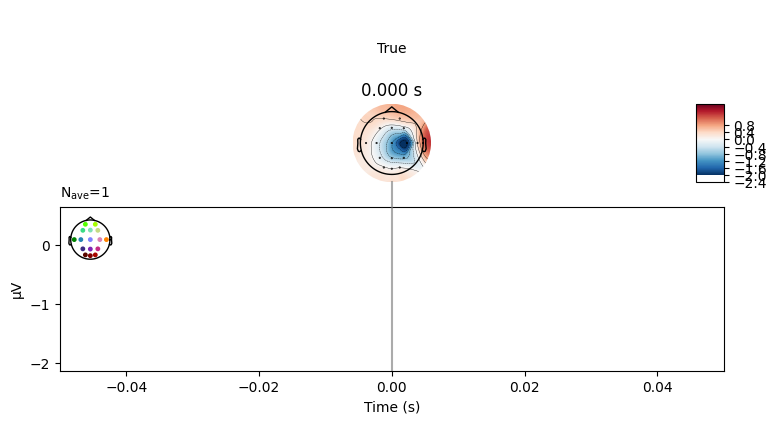

In [7]:
%matplotlib qt

settings = dict(number_of_sources=1, extents=1, duration_of_trial=0.0, target_snr=99999999999)
# settings = dict(number_of_sources=4, extents=(1, 40), duration_of_trial=0, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint(title=f"True", times=[0,])

# Algo

In [ ]:
from scipy.optimize import minimize

print(x.shape, y.shape)
constr = dict(type="eq", fun=lambda x: np.linalg.norm(leadfield @ x - y))

def l1_norm(x):
    return np.linalg.norm(x, ord=1)

def data_loss(leadfield, y):
    def loss(x_est):
        return np.linalg.norm(leadfield @ x_est - y)
    return loss

options = dict(maxiter=100)
tol = 1e-6
x0 = np.linalg.pinv(leadfield) @ y
res = minimize(data_loss(leadfield, y), x0, method="SLSQP", options=options, tol=tol)
src_hat_1 = res["x"]

# res = minimize(l1_norm, x0, method="SLSQP", constraints=constr, options=options, tol=tol)
# src_hat_2 = res["x"]

In [ ]:
stc_hat = stc.copy()
stc_hat.data = src_hat_1[:, np.newaxis]
stc_hat.data /= np.max(abs(stc_hat.data))
stc_hat.plot(**pp, brain_kwargs=dict(title="Scipy Version"))

# Nullspace Solution

In [ ]:
import numpy as np
from scipy.linalg import qr


def qr_null(A, tol=None):
    """Computes the null space of A using a rank-revealing QR decomposition"""
    Q, R, P = qr(A.T, mode='full', pivoting=True)
    tol = np.finfo(R.dtype).eps if tol is None else tol
    rnk = min(A.shape) - np.abs(np.diag(R))[::-1].searchsorted(tol)
    return Q[:, rnk:].conj()


# An underdetermined system with nullity 2
A = deepcopy(leadfield)
b = deepcopy(y)

# Find an initial solution using `np.linalg.lstsq`
x_lstsq = np.linalg.lstsq(A, b)[0]

# Compute the null space of `A`
Z = qr_null(A)
nullity = Z.shape[1]

# Sample some random solutions
for _ in range(100):
    x_rand = x_lstsq + Z.dot(np.random.rand(nullity))
    # If `x_rand` is a solution then `||A·x_rand - b||` should be very small
    print(np.linalg.norm(A.dot(x_rand) - b))

In [ ]:
%matplotlib qt

from esinet import util

stc_hat = stc.copy()
stc_hat.data = x_rand.T
stc_hat.data /= np.max(abs(stc_hat.data))
stc_hat.plot(**pp, brain_kwargs=dict(title="Stack Overflow Version"))

evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
evoked_.plot_joint(title=f"Predicted", times=[0,])


# Nullspace Solution 2

In [26]:
import numpy as np
from numpy.linalg import lstsq

# rank_nullspace from
# http://scipy-cookbook.readthedocs.io/items/RankNullspace.html

#!python
import numpy as np
from numpy.linalg import svd


def rank(A, atol=1e-13, rtol=0):
    """Estimate the rank (i.e. the dimension of the nullspace) of a matrix.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length n will be treated
        as a 2-D with shape (1, n)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    r : int
        The estimated rank of the matrix.

    See also
    --------
    numpy.linalg.matrix_rank
        matrix_rank is basically the same as this function, but it does not
        provide the option of the absolute tolerance.
    """

    A = np.atleast_2d(A)
    s = svd(A, compute_uv=False)
    tol = max(atol, rtol * s[0])
    rank = int((s >= tol).sum())
    return rank


def nullspace(A, atol=1e-3, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

def randsol(A, b, num=1, check=False):
    xLS, *_ = lstsq(A, b)

    colsOfNullspace = nullspace(A)
    nullrank = colsOfNullspace.shape[1]
    if check:
        assert(np.allclose(np.dot(A, xLS), b))
        assert(np.allclose(np.dot(A, xLS + np.dot(colsOfNullspace,
                                                  np.random.randn(nullrank))),
                           b))

    sols = xLS[:, np.newaxis] + np.dot(colsOfNullspace,
                                       np.random.randn(nullrank, num))
    return sols


A = deepcopy(leadfield)
b = deepcopy(y[:, 0])
x = randsol(A, b, num=int(1e5), check=False)


Using control points [0.61498703 0.67057174 0.95078763]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


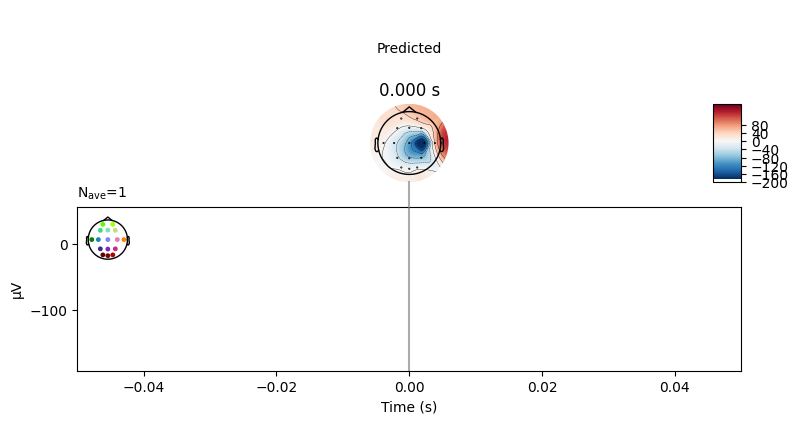

Using control points [0.61498703 0.67057174 0.95078763]


In [27]:
%matplotlib qt

from esinet import util
# data = (x.mean(axis=-1) / x.std(axis=-1))[:, np.newaxis]
data = x.mean(axis=-1)[:, np.newaxis]

stc_hat = stc.copy()
stc_hat.data = data
stc_hat.data /= np.max(abs(stc_hat.data))
stc_hat.plot(**pp, brain_kwargs=dict(title="Stack Overflow Version 2"))

evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
evoked_.plot_joint(title=f"Predicted", times=[0,])


In [18]:
for i, sol in enumerate(x.T):
    sol_max = deepcopy(sol)
    sol_max[abs(sol_max) < abs(sol_max).max()] = 0
    x[:, i] = sol_max